## Problem 2: Calculate and visualise the *dominance areas* of shopping centres (10 points)

In this problem, the aim is to delineate the dominance area of each shopping centre. For this 
exercise, we define the ‘dominance area’ of a shopping centre as the area from which it can 
be reached faster than other shopping centres. We will use public transport travel times.

![](images/dominance_areas_example_1000x500px.png)

*Sample result: a map showing the areas of dominance of each shopping centre, and the travel 
times to the closest shopping centre in the entire metropolitan area*



---

### Data

The **input data** is identical to what you have used for *problem 1*, 
see [there](./Exercise-4-problem-1.ipynb) for detailed data descriptions.

---


### An overview of the tasks

This task comprises of three major subtasks. In contrast to earlier exercises, we 
do not provide a detailed, step-by-step ‘cooking recipe’. Rather, you are free to
implement the necessary steps in any order you see fit, and choose any variable
names of your liking. 

To test intermediate results, implement `assert` statements, output the `head()`
of a data frame, or plot the data. Remember to add comments to all of your code,
so future you (and us) can understand what each section does.

The **only strict requirement** is the **file name** of
the **output** map plot: `DATA_DIRECTORY / "dominance_areas.png"`.

1. Load the YKR grid and the individual travel time data sets, and combine them 
   into one geo data frame. This is essentially the same as *problem 1*, except
   that you must load all eight shopping centre data files. (2 points)
2. Find the closest shopping centre to each grid cell. In the combined data set,
   find the minimum travel time to any of the shopping centres, save the value in
   a new column, and shopping centre name in another new column. (4 points)
   See the [hints](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-4/exercise-4.html#hints)
   to this exercise for a suggestions on how to achieve this 
   ([`pandas.DataFrame.min()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.min.html) and
   [`pandas.DataFrame.idxmin()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html)
   will be helpful)
3. Visualise the dominance areas and travel times. Use 2⨉1 subplots to plot
   the most dominant (closest) shopping centre for each grid cell, and the
   travel time to the closest shopping centre for each grid cell. (4 points)

---


In [2]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / 'data'

In [3]:
import geopandas
import pandas as pd
import numpy as np

grid = geopandas.read_file(DATA_DIRECTORY / 'YKR_grid_EPSG3067.gpkg')
travel_time_files = [f for f in DATA_DIRECTORY.glob('*.txt') if 'travel_times_to_' in f.name]

for file in travel_time_files:
    #extract name
    shopping_centre = file.stem.split('_')[-1]  
    
    travel_data = pd.read_csv(file, sep=';')
    travel_data = travel_data[['from_id', 'pt_r_t', 'car_r_t']]
    
    travel_data.rename(columns={
        'pt_r_t': f'pt_r_t_{shopping_centre}', 
        'car_r_t': f'car_r_t_{shopping_centre}'
    }, inplace=True)
    
    travel_data.replace({f'pt_r_t_{shopping_centre}': -1, f'car_r_t_{shopping_centre}': -1}, np.nan, inplace=True)
    
    #from_id' for joining
    travel_data.set_index('from_id', inplace=True)
    grid = grid.join(travel_data, how='left', on='YKR_ID')

grid.reset_index(inplace=True)

grid.head()


,index,YKR_ID,geometry,pt_r_t_Jumbo,car_r_t_Jumbo,pt_r_t_Dixi,car_r_t_Dixi,pt_r_t_Myyrmanni,car_r_t_Myyrmanni,pt_r_t_Itis,car_r_t_Itis,pt_r_t_Forum,car_r_t_Forum,pt_r_t_Omena,car_r_t_Omena,pt_r_t_Ruoholahti,car_r_t_Ruoholahti
0,0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",101.0,39.0,102.0,45.0,90.0,39.0,132.0,50.0,110.0,49.0,141.0,56.0,118.0,56.0
1,1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",108.0,39.0,109.0,45.0,93.0,39.0,135.0,51.0,113.0,49.0,143.0,56.0,121.0,56.0
2,2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",109.0,45.0,111.0,52.0,95.0,47.0,137.0,58.0,115.0,57.0,145.0,64.0,123.0,63.0
3,3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",114.0,46.0,115.0,48.0,99.0,51.0,141.0,57.0,119.0,60.0,149.0,67.0,127.0,67.0
4,4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",98.0,38.0,99.0,44.0,83.0,38.0,125.0,50.0,103.0,48.0,134.0,55.0,111.0,55.0


In [7]:
#minimum travel time
centres = [file.stem.split("_")[-1] for file in travel_time_files]

grid['min_travel_time'] = grid[[f'pt_r_t_{centre}' for centre in centres]].min(axis=1)
grid['closest_centre'] = grid[[f'pt_r_t_{centre}' for centre in centres]].idxmin(axis=1)

#get name
grid['closest_centre'] = grid['closest_centre'].str.replace('pt_r_t_', '')

print(grid[['min_travel_time', 'closest_centre']].head())


   min_travel_time closest_centre
0             90.0      Myyrmanni
1             93.0      Myyrmanni
2             95.0      Myyrmanni
3             99.0      Myyrmanni
4             83.0      Myyrmanni


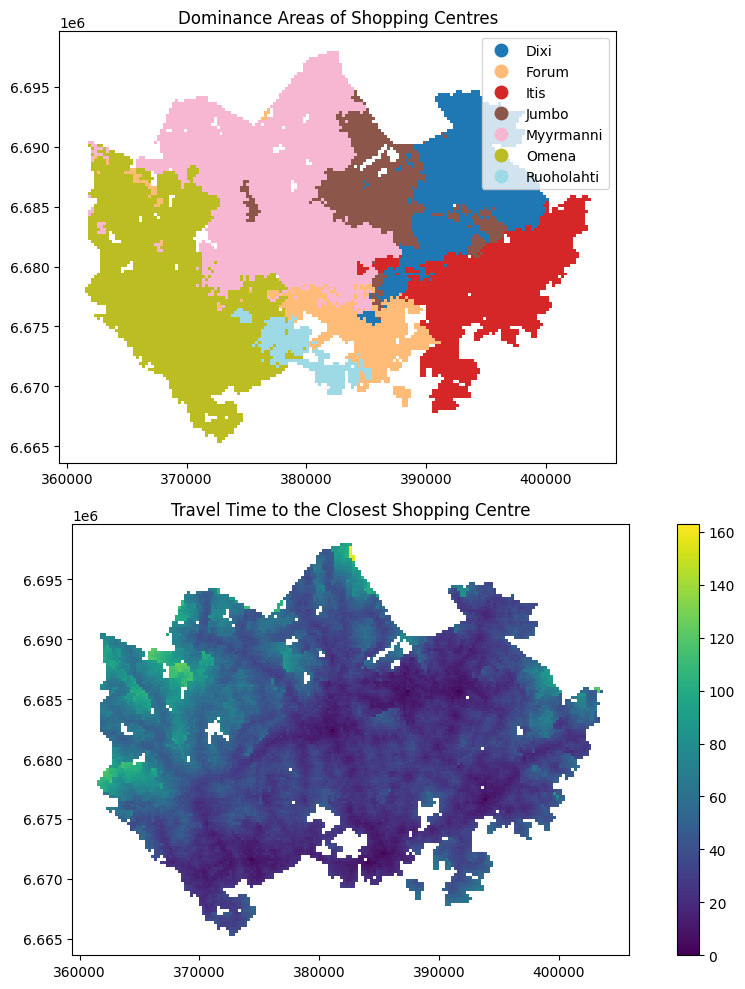

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

grid.plot(column='closest_centre', ax=axs[0], legend=True, cmap='tab20', categorical=True)
axs[0].set_title('Dominance Areas of Shopping Centres')

grid.plot(column='min_travel_time', ax=axs[1], legend=True, cmap='viridis')
axs[1].set_title('Travel Time to the Closest Shopping Centre')

plt.tight_layout()
plt.savefig(DATA_DIRECTORY / "dominance_areas.png")

plt.show()


In [ ]:
# ADD YOUR OWN CODE HERE


In [9]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
assert (DATA_DIRECTORY / "dominance_areas.png").exists()


--- 

**Do not forget to plot the result map, and save it to `DATA_DIRECTORY / "dominance_areas.png"`!**

---

## Reflections

This was a significantly more complex exercise that previous ones, and it included finding
a solution yourself. 

- What was most difficult part? 
- Where did you get stuck? 
- What was the easiest, and
- what was the most fun part of this exercise?

Add your answer below


---

## Well done!

Congratulations, you completed exercise 4. Good Job!